In [1]:
import numpy as np
from keras.applications import densenet, VGG16
from keras.preprocessing import image
from keras.activations import relu, softmax
import keras.backend as K
import matplotlib.pyplot as plt
from keras import applications
%matplotlib inline

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, save_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam
from keras.backend.tensorflow_backend import set_session

Using TensorFlow backend.


In [2]:
img_width = 224
img_height =224
img_path = '/home/tang/targa/image_size_exp/test_pretraining_inceptionv3/test_images/guitar/acoustic_guitar/n02676566_10012.JPEG'
img_path = 'orange.jpg'
input_img = image.load_img(img_path, target_size=(img_width,img_height))
x = image.img_to_array(input_img)
x = np.expand_dims(x, axis=0)
input_img = densenet.preprocess_input(x)

In [3]:
model = VGG16(weights='imagenet',include_top = False)


model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [4]:
x = [l for l in model.layers]

layer_name = x[5].name
filter_index = 2

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])


In [5]:
layer_name

'block2_conv2'

In [6]:
#K.gradients return a list of tensor
grads = K.gradients(loss,model.input)[0]

#Let us apply the "tensor trick"
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [7]:
input_img.shape

(1, 224, 224, 3)

In [8]:
iterate = K.function([model.input],[loss,grads])

# loss_value, grads_value = iterate([np.zeros((1,img_width,img_height,3))])
loss_value, grads_value = iterate([input_img])

In [9]:
# input_img_data = np.random.random((1,img_width,img_height,3)) * 20 + 128.

# step = 1
# for i in range(40):
#     loss_value, grads_value = iterate([(input_img_data)])
#     input_img_data += grads_value * step


In [10]:
def deprocess_image(x):
    #Normalize image
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    #Clip to 0/1
    x += 0.5
    x = np.clip(x,0,1)
    #Convert to RGB
    x *= 255
    x = np.clip(x,0,255).astype('uint8')
    return x

In [11]:
def generate_pattern(layer_name, filter_index,size=img_width):
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:,:,:,filter_index])
    grads = K.gradients(loss,model.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model.input],[loss,grads])
    
    input_img_data = np.random.random((1,size,size,3)) * 20 + 128.
    input_img_data = np.reshape(input_img,(1,img_width,img_height,3))
    
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

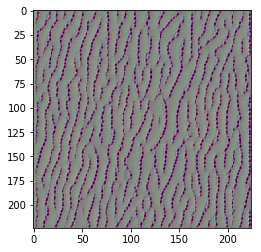

In [12]:
plt.imshow(generate_pattern(layer_name,1))

In [13]:
generate_pattern(layer_name,0).shape

(224, 224, 3)

In [16]:
size = img_height
margin = 1

results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

for i in range(8):
    for j in range(8):
        filter_img = generate_pattern(layer_name, i + (j * 8), size = size)
        #plt.imshow(filter_img/255.0)
        #print(i,j)
        horizontal_start = i * size + i * margin
        horizontal_end = horizontal_start + size
        vertical_start = j * size + j * margin
        vertical_end = vertical_start + size
        results[horizontal_start : horizontal_end,
               vertical_start:vertical_end,:] = filter_img/255.0
        
# plt.figure(figsize=(20,20))
# plt.imshow(results)

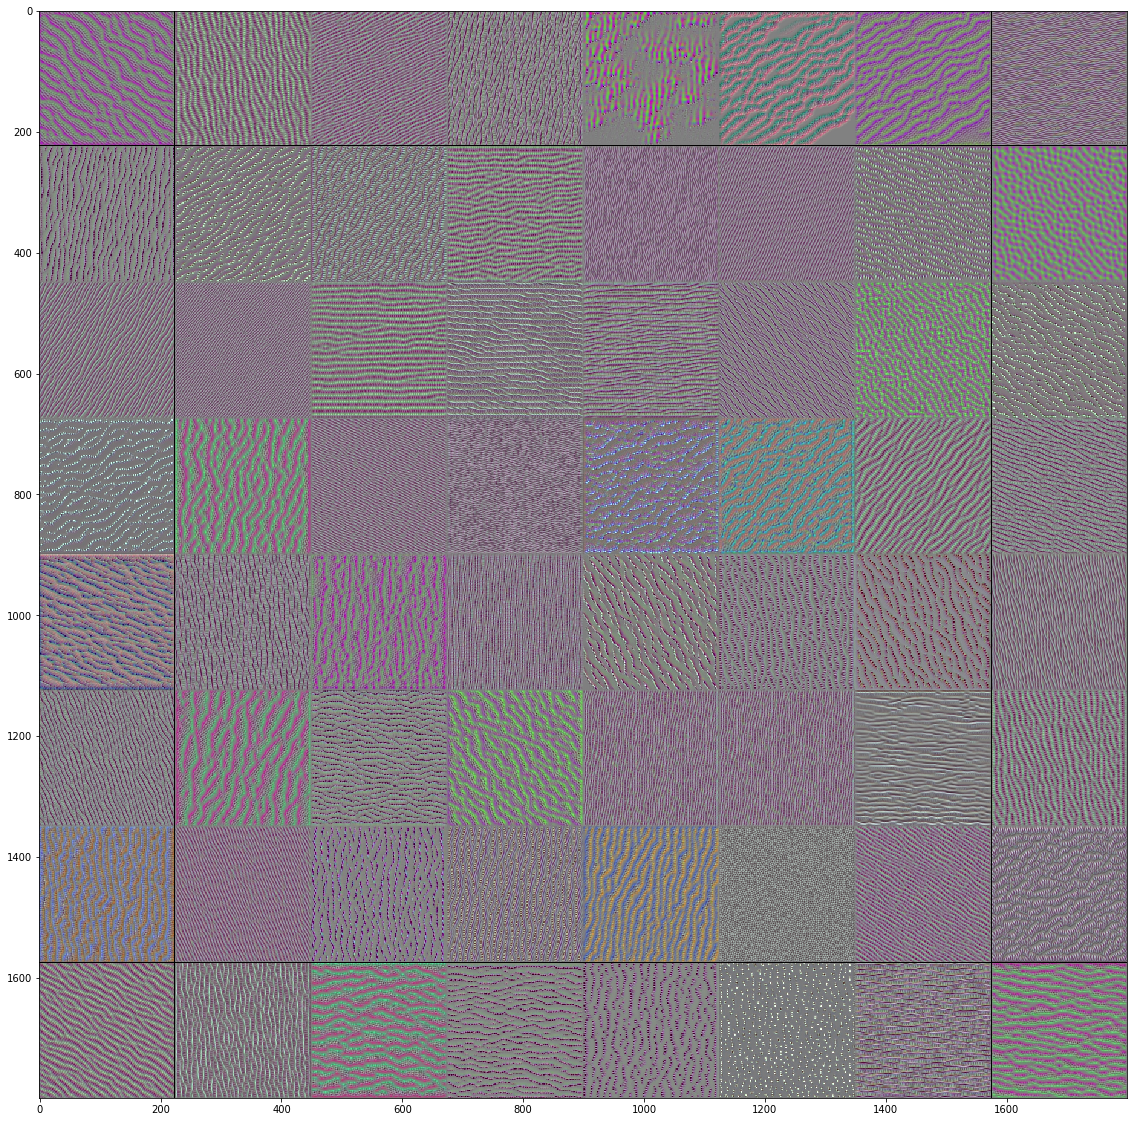

In [17]:
plt.figure(figsize=(20,20))
plt.imshow(results)